# Traffic Sign Recognition with Tensorflow

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import color

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.optimizers import RMSprop

# Allow image embeding in notebook
%matplotlib inline

/home/adam/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/adam/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/adam/.local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/adam/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/adam/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, m

## Dataset

Belgian Traffic Sign数据集包含训练和测试两部分:	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

在下载和解压之后，以如下目录结构存放数据集，data目录位于当前notebook同目录下:

```
data/Training/
data/Testing/
```

每个文件夹包含了62个类，编号从 00000 到 00061. 

## 读取数据集

In [3]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "data"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_dir)

## 探索数据集

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


Display the first image of each label.

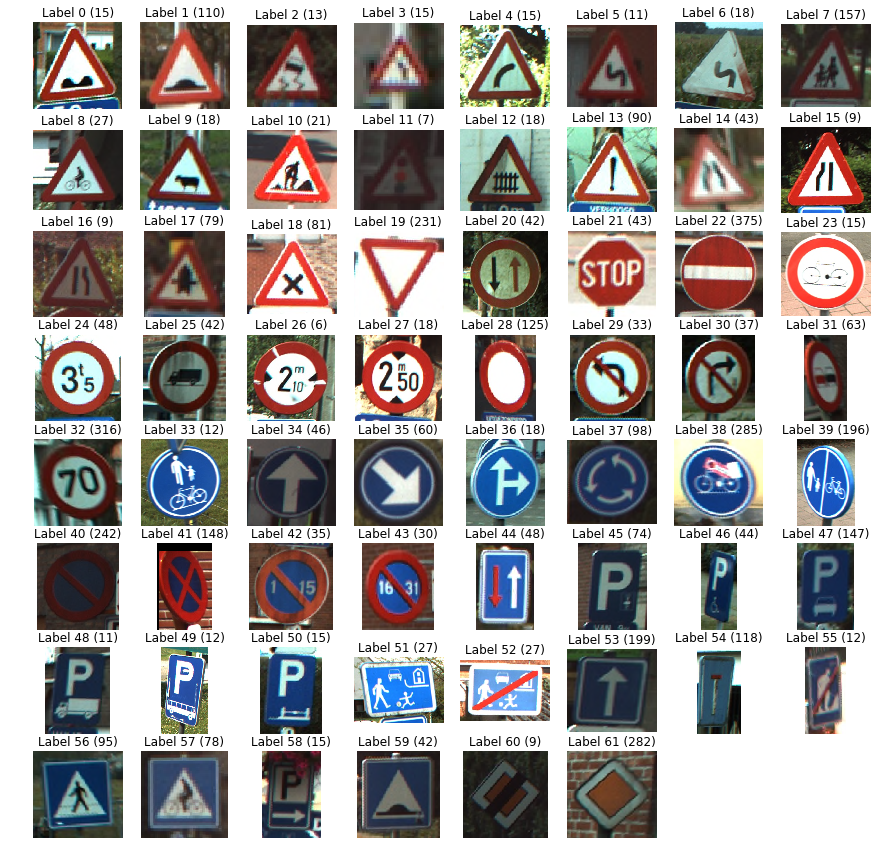

In [5]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

## Resize图片

大多数神经网络需要一个固定大小的输入。但正如上面我们看到的,我们的图片不都是一样的尺寸。我们使用一个简单的方法进行处理，直接将图片resize成相同的尺寸。


/home/adam/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


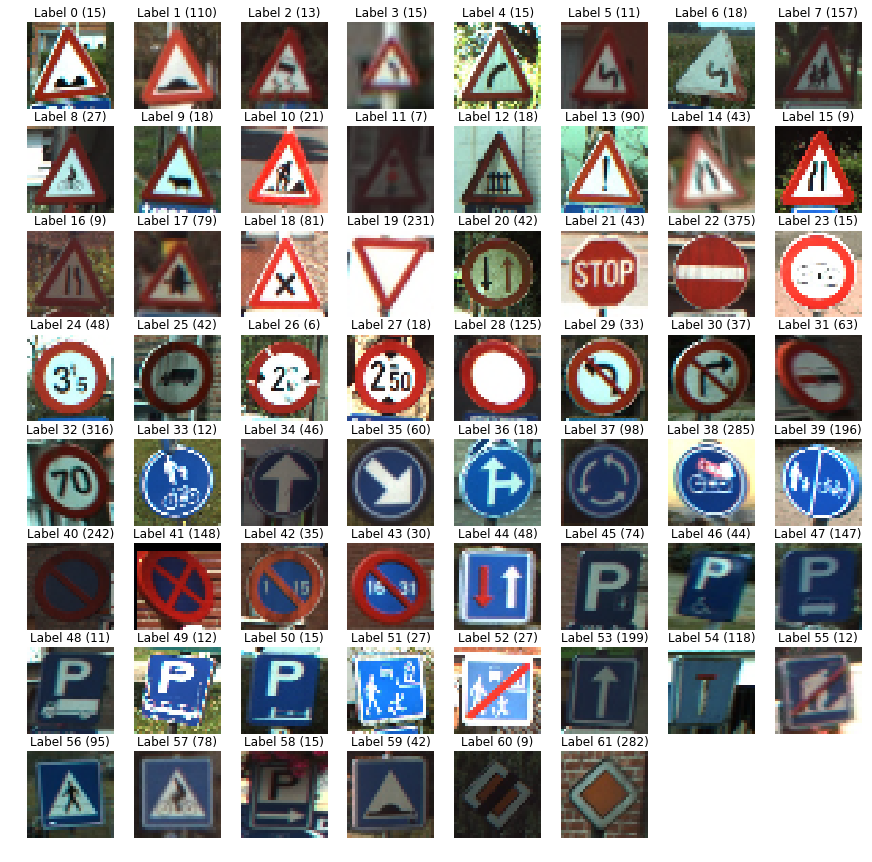

In [6]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

虽然图像被缩小至32x32但是对人来说仍然可以识别。

In [7]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0214307598039, max: 1.0
shape: (32, 32, 3), min: 0.0450367647059, max: 1.0
shape: (32, 32, 3), min: 0.0052428002451, max: 0.999942555147
shape: (32, 32, 3), min: 0.012025122549, max: 0.983042279412
shape: (32, 32, 3), min: 0.00294117647059, max: 1.0


图像的像素点值已经被归一化了（0～1）

## 将图像转为numpy array

In [8]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (4575,), '\nimages: ', (4575, 32, 32, 3))


## 将图像转为灰度图
对图像进行一定的预处理，在本例中，我们将原来的RGB三通道的图像转换为灰度图

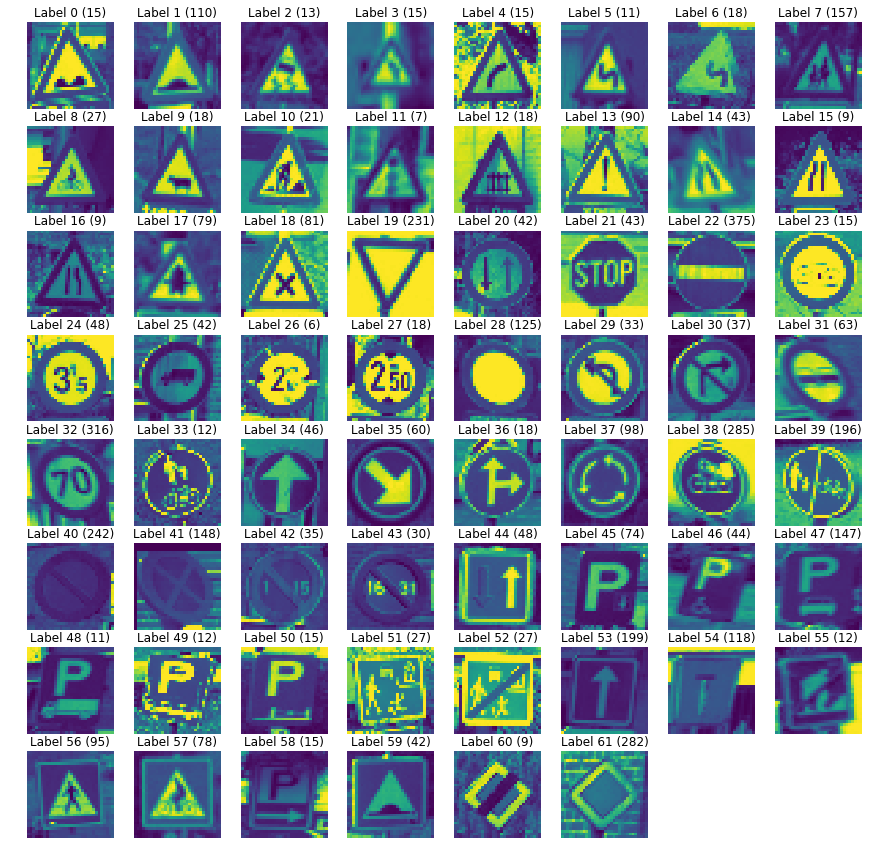

In [9]:
images_a = color.rgb2gray(images_a)
display_images_and_labels(images_a, labels)

In [10]:
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (4575,), '\nimages: ', (4575, 32, 32))


## 数据集增强，通过随机的平移和旋转扩充数据

In [11]:
def expend_training_data(train_x, train_y):
    """
    Augment training data
    """
    expanded_images = np.zeros([train_x.shape[0] * 5, train_x.shape[1], train_x.shape[2]])
    expanded_labels = np.zeros([train_x.shape[0] * 5])

    counter = 0
    for x, y in zip(train_x, train_y):

        # register original data
        expanded_images[counter, :, :] = x
        expanded_labels[counter] = y
        counter = counter + 1

        # get a value for the background
        # zero is the expected value, but median() is used to estimate background's value
        bg_value = np.median(x)  # this is regarded as background's value

        for i in range(4):
            # rotate the image with random degree
            angle = np.random.randint(-15, 15, 1)
            new_img = ndimage.rotate(x, angle, reshape=False, cval=bg_value)

            # shift the image with random distance
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img, shift, cval=bg_value)

            # register new training data
            expanded_images[counter, :, :] = new_img_
            expanded_labels[counter] = y
            counter = counter + 1

    return expanded_images, expanded_labels

images_a, labels_a = expend_training_data(images_a, labels_a)
print(images_a.shape, labels_a.shape)
labels = labels_a.tolist()
print(len(labels))

((22875, 32, 32), (22875,))
22875


训练集被扩充为原来的5倍，下面我们展示几个样本

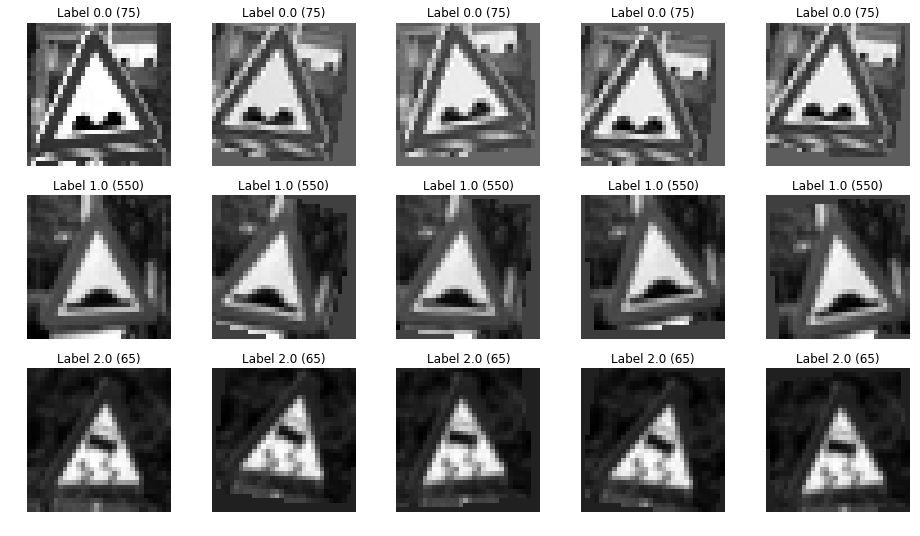

In [12]:
def plot_agument(images, labels):
    plt.figure(figsize=(16, 9))
    unique_labels = set(labels)
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        if i > 3:
            break
        img_index = labels.index(label)
        for j in range(5):
            image = images_a[img_index+j]
            plt.subplot(3, 5, (i-1)*5 + j+1)  # A grid of 8 rows x 8 columns
            plt.axis('off')
            plt.title("Label {0} ({1})".format(label, labels.count(label)))
            _ = plt.imshow(image, cmap='gray')
        i += 1

plot_agument(images_a, labels)

In [13]:
from sklearn.utils import shuffle

indx = np.arange(0, len(labels_a))
indx = shuffle(indx)
images_a = images_a[indx]
labels_a = labels_a[indx]

print(images_a.shape, labels_a.shape)

((22875, 32, 32), (22875,))


/home/adam/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32


In [14]:
train_x, val_x = images_a[:20000], images_a[20000:]
train_y, val_y = labels_a[:20000], labels_a[20000:]

train_y = keras.utils.to_categorical(train_y, 62)
val_y = keras.utils.to_categorical(val_y, 62)
print(train_x.shape, train_y.shape)

((20000, 32, 32), (20000, 62))


In [15]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(val_x, val_y))

### print the keys contained in the history object
print(history.history.keys())
model.save('model.json')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 62)                31806     
Total params: 819,262.0
Trainable params: 819,262.0
Non-trainable par

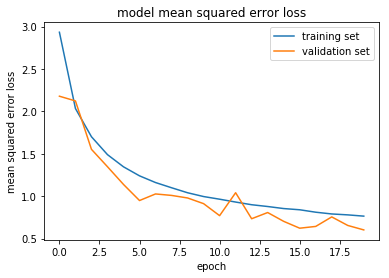

In [16]:
def plot_training(history):
    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

plot_training(history=history)

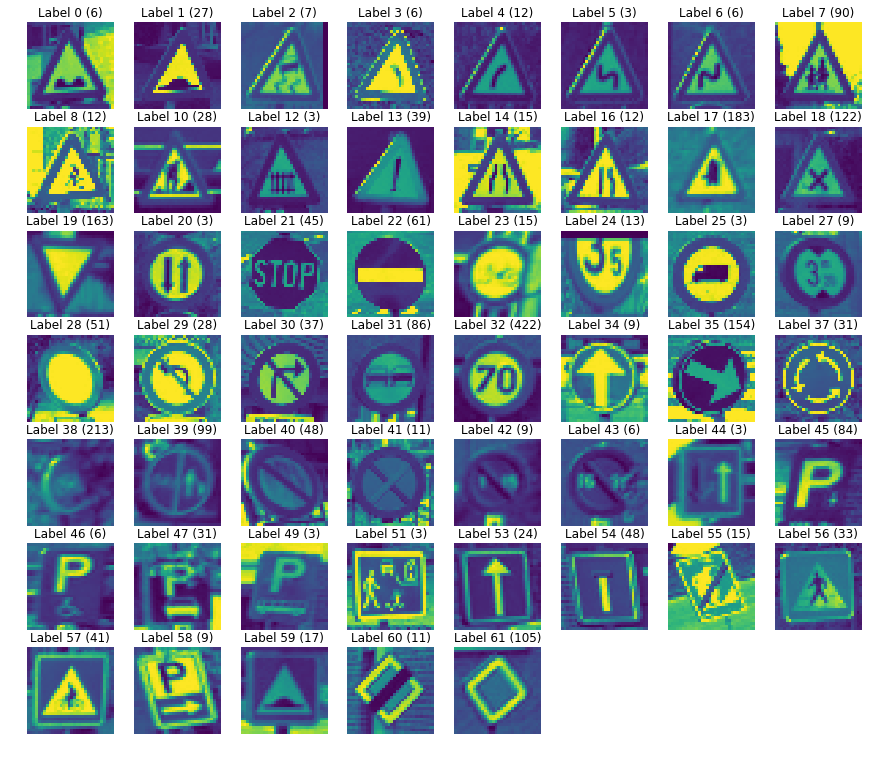

In [17]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]

test_images_a = np.array(test_images32)
test_labels_a = np.array(test_labels)

test_images_a = color.rgb2gray(test_images_a)

display_images_and_labels(test_images_a, test_labels)

In [18]:
test_x = test_images_a
test_y = keras.utils.to_categorical(test_labels_a, 62)
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.5486441658070637)
('Test accuracy:', 0.855158729969509)


In [19]:
predicted = model.predict(test_x)
predicted = np.argmax(predicted, 1)
print(predicted.shape)

(2520,)


## 使用模型

展示几个样本的预测结果

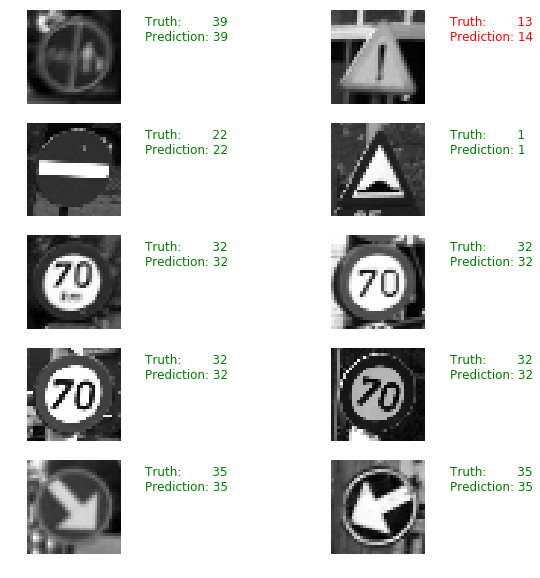

In [20]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
j = 1
for i in range(0, 1000, 100):
    truth = test_labels_a[i]
    prediction = predicted[i]
    plt.subplot(5, 2, j)
    j = j+1 
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(test_x[i], cmap='gray')
